In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-05-02 18:48:48.930992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 18:48:48.938928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746211728.947864   25227 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746211728.950460   25227 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746211728.957281   25227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:


import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2 
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Conv2DTranspose,concatenate,Input,Dropout
from tensorflow.keras.utils import to_categorical



E0000 00:00:1746212093.622188   27087 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746212093.625187   27087 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746212093.631620   27087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746212093.631630   27087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746212093.631631   27087 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746212093.631632   27087 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:


# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)



REPLICAS:  1


In [3]:


train_img_path='cam_data/train'
train_label_path='cam_data/train_labels'

val_img_path='cam_data/val'
val_label_path='cam_data/val_labels'

test_img_path='cam_data/test'
test_label_path='cam_data/test_labels'



In [4]:
df=pd.read_csv('cam_data/class_dict.csv')
df.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


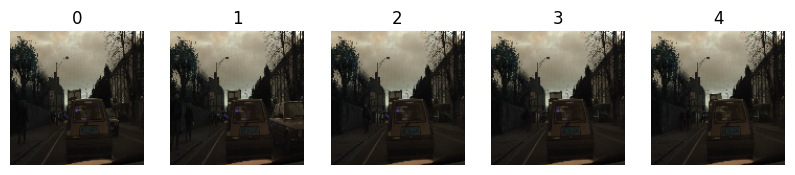

In [5]:
train_img=[]

train_img_dir=sorted(os.listdir(train_img_path))
test_img_dir=sorted(os.listdir(test_img_path))


for name in train_img_dir:
    image=cv2.imread(os.path.join(train_img_path,name))
    image=cv2.resize(image,(128,128))
    train_img.append(image)
    
for test_name in test_img_dir:
    image=cv2.imread(os.path.join(test_img_path,test_name))
    image=cv2.resize(image,(128,128))
    train_img.append(image)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_img[i])
    plt.axis('off')
    plt.title(i)

libpng warning: iCCP: known incorrect sRGB profile


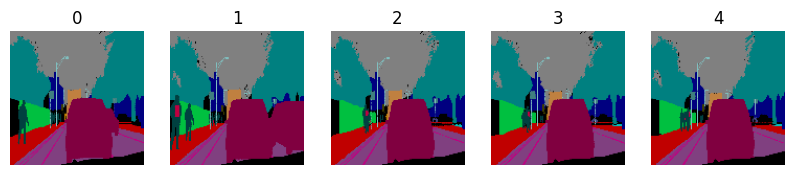

In [6]:
train_label=[]

train_label_dir=sorted(os.listdir(train_label_path))
test_label_dir=sorted(os.listdir(test_label_path))


for name in train_label_dir:
    label=cv2.imread(os.path.join(train_label_path,name))
    label=cv2.resize(label,(128,128))
    train_label.append(label)
    
for test_name in test_label_dir:
    label=cv2.imread(os.path.join(test_label_path,test_name))
    label=cv2.resize(label,(128,128))
    train_label.append(label)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_label[i])
    plt.axis('off')
    plt.title(i)

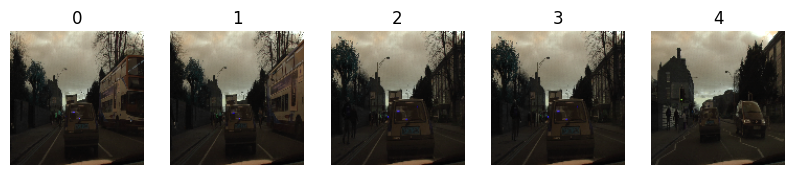

In [7]:
val_img=[]
val_img_dir=sorted(os.listdir(val_img_path))

for name in val_img_dir:
    image=cv2.imread(os.path.join(val_img_path,name))
    image=cv2.resize(image,(128,128))
    val_img.append(image)
    
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(val_img[i])
    plt.title(i)
    plt.axis('off')



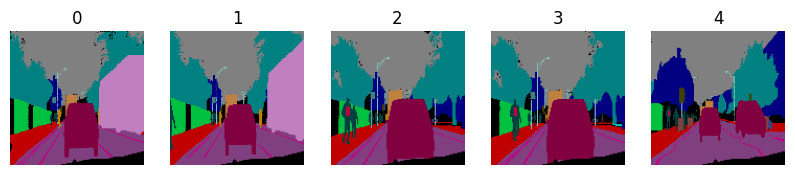

In [8]:
val_label=[]
val_label_dir=sorted(os.listdir(val_label_path))

for name in val_label_dir:
    label=cv2.imread(os.path.join(val_label_path,name))
    label=cv2.resize(label,(128,128))
    val_label.append(label)
    
plt.figure(figsize=(10,10))
for i in range (5):
    plt.subplot(1,5,i+1)
    plt.imshow(val_label[i])
    plt.title(i)
    plt.axis('off')

In [9]:
train_img=np.array(train_img)/255
train_label=np.array(train_label)/255

val_img=np.array(val_img)/255
val_label=np.array(val_label)/255

In [10]:


print(f'Train Shape :\n{train_img.shape}\n{train_label.shape}\n\nVal Shape:  \n{val_img.shape}\n{val_label.shape}')



Train Shape :
(601, 128, 128, 3)
(601, 128, 128, 3)

Val Shape:  
(100, 128, 128, 3)
(100, 128, 128, 3)


In [11]:


train_label=to_categorical(np.argmax(train_label,axis=-1),num_classes=32)
val_label=to_categorical(np.argmax(val_label,axis=-1),num_classes=32)



In [12]:
inputs=Input((128,128,3))

c1 = Conv2D(64,(3,3),padding='same',activation='relu')(inputs)
b1 = BatchNormalization()(c1)
c1 = Conv2D(64,(3,3),padding='same',activation='relu')(b1)
b1 = BatchNormalization()(c1)
p1 = MaxPooling2D()(b1)
d1 = Dropout(0.2)(p1)

c2 = Conv2D(128,(3,3),padding='same',activation='relu')(d1)
b2 = BatchNormalization()(c2)
c2 = Conv2D(128,(3,3),padding='same',activation='relu')((b2))
b2 = BatchNormalization()(c2)
p2 = MaxPooling2D()(b2)
d2 = Dropout(0.3)(p2)

c3 = Conv2D(256,(3,3),padding='same',activation='relu')(d2)
b3 = BatchNormalization()(c3)
c3 = Conv2D(256,(3,3),padding='same',activation='relu')(b3)
b3 = BatchNormalization()(c3)
p3 = MaxPooling2D()(b3)
d3 = Dropout(0.4)(p3)

c4 = Conv2D(512,(3,3),padding='same',activation='relu')(d3)
b4 = BatchNormalization()(c4)
c4 = Conv2D(512,(3,3),padding='same',activation='relu')(b4)
b4 = BatchNormalization()(c4)
p4 = MaxPooling2D()(b4)



c5 = Conv2D(1024,(3,3),padding='same',activation='relu')(p4)
b5 = BatchNormalization()(c5)
c5 = Conv2D(1024,(3,3),padding='same',activation='relu')(b5)
b5 = BatchNormalization()(c5)



u6 = Conv2DTranspose(512,(2,2),strides=(2,2),padding='same',activation='relu')(b5)
u6 = concatenate([u6,c4])
c6 = Conv2D(512,(3,3),padding='same',activation='relu')(u6)
b6 = BatchNormalization()(c6)
c6 = Conv2D(512,(3,3),padding='same',activation='relu')(b6)
b6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same',activation='relu')(c6)
u7 = concatenate([u7,b3])
c7 = Conv2D(256,(3,3),padding='same',activation='relu')(u7)
b7 = BatchNormalization()(c7)
c7 = Conv2D(256,(3,3),padding='same',activation='relu')(b7)
b7 = BatchNormalization()(c7)
d7 = Dropout(0.4)(b7)

u8 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same',activation='relu')(d7)
u8 = concatenate([u8,b2])
c8 = Conv2D(128,(3,3),padding='same',activation='relu')(u8)
b8 = BatchNormalization()(c8)
c8 = Conv2D(128,(3,3),padding='same',activation='relu')(b8)
b8 = BatchNormalization()(c8)
d8 = Dropout(0.3)(b8)

u9 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same',activation='relu')(d8)
u9 = concatenate([u9,b1])
c9 = Conv2D(64,(3,3),padding='same',activation='relu')(u9)
b9 = BatchNormalization()(c9)
c9 = Conv2D(64,(3,3),padding='same',activation='relu')(b9)
b9 = BatchNormalization()(c9)
d9 = Dropout(0.2)(b9)

outputs=Conv2D(32,(1,1),padding='same',activation='softmax')(d9)

model=tf.keras.Model(inputs , outputs,name='U-Net')
model.summary()

I0000 00:00:1746212265.301653   27087 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,055,264 (118.47 MB)

 Trainable params: 31,044,512 (118.43 MB)

 Non-trainable params: 10,752 (42.00 KB)

In [13]:
decay=tf.keras.optimizers.schedules.ExponentialDecay(0.0001, 
                                                     decay_steps=1500,
                                                     decay_rate=0.5)


def scheduler(lr,epochs):
    if epochs <40:
        return lr
    elif epochs >=40:
        return lr * 0.5

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=tf.keras.optimizers.Adam(decay),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_img,train_label,
                    validation_data=(val_img,val_label),
                    epochs=200,
                    batch_size=16,
                    )

Epoch 1/200


I0000 00:00:1746212305.812759   27723 service.cc:152] XLA service 0x7f5db0015ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746212305.812845   27723 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
I0000 00:00:1746212306.761370   27723 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746212329.134970   27723 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - accuracy: 0.2043 - loss: 3.5067 - val_accuracy: 0.6109 - val_loss: 3.2712
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.6931 - loss: 1.6837 - val_accuracy: 0.6142 - val_loss: 2.8686
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.7786 - loss: 1.2042 - val_accuracy: 0.6142 - val_loss: 2.9548
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8425 - loss: 0.9556 - val_accuracy: 0.7150 - val_loss: 1.9861
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8684 - loss: 0.8059 - val_accuracy: 0.6142 - val_loss: 2.7726
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.8801 - loss: 0.7001 - val_accuracy: 0.6142 - val_loss: 2.4106
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.8887 - loss: 0.6257 - val_accuracy: 0.7106 - val_loss: 1.4696
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.8971 - loss: 0.5678 - val_accuracy: 0.737

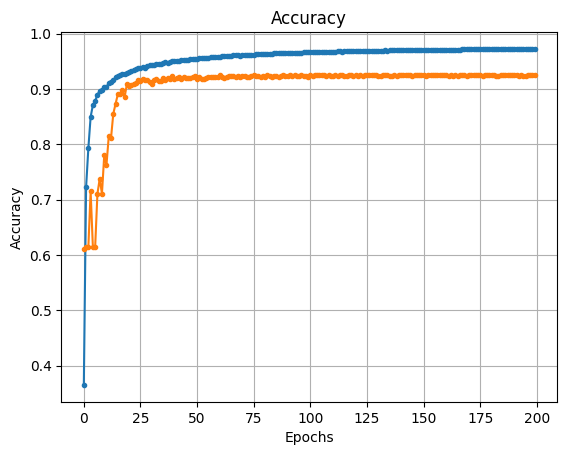

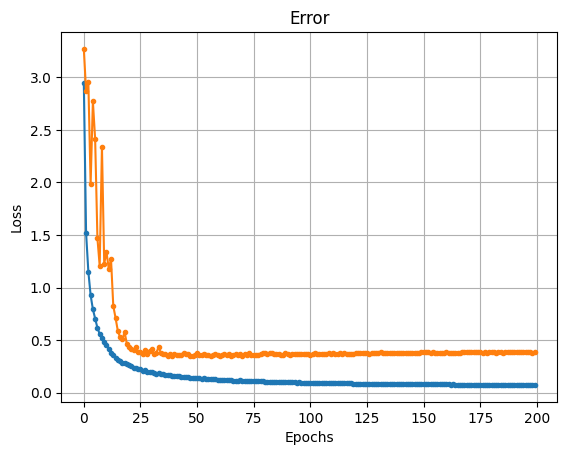

In [14]:
plt.plot(history.history['accuracy'],marker='.')
plt.plot(history.history['val_accuracy'],marker='.')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.show()

plt.plot(history.history['loss'],marker='.')
plt.plot(history.history['val_loss'],marker='.')
plt.title('Error')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [15]:
model.evaluate(val_img,val_label)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9207 - loss: 0.3992


[0.38507598638534546, 0.9247833490371704]

In [16]:
pred=model.predict(val_img)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step


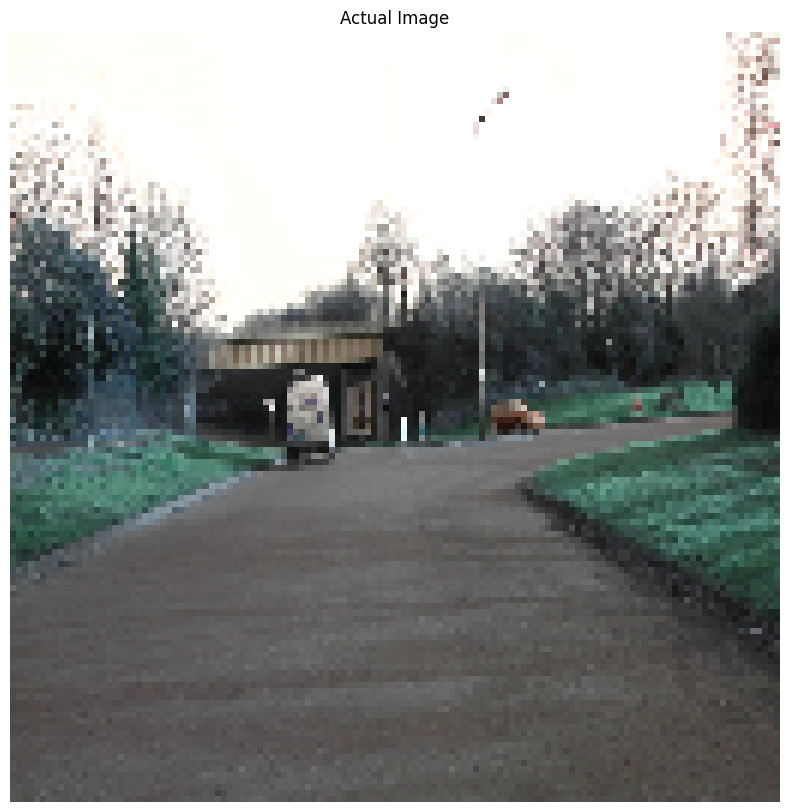

In [17]:
plt.figure(figsize=(10,10))

plt.imshow(val_img[11])
plt.axis('off')
plt.title('Actual Image')
plt.show()

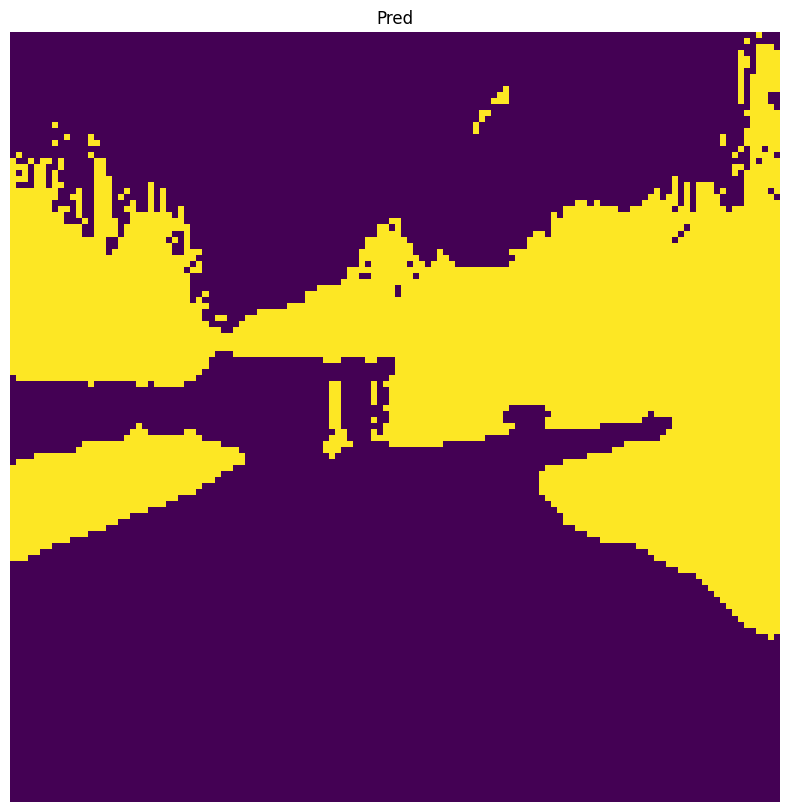

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(np.argmax(pred[11],axis=-1))
plt.axis('off')
plt.title('Pred')
plt.show()

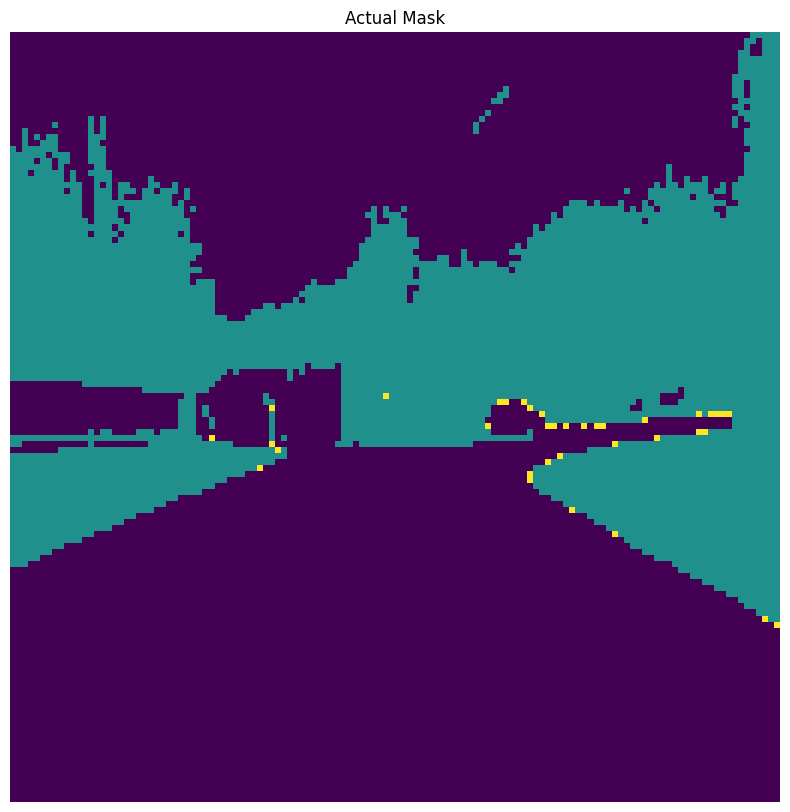

In [19]:
plt.figure(figsize=(10,10))

plt.imshow(np.argmax(val_label[11],axis=-1))
plt.axis('off')
plt.title('Actual Mask')
plt.show()

In [21]:
model.save('saved_model/unet_main_model.h5')